In [207]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [208]:
import sys
sys.path.append("C:/Users/maher/Unsupervised-anomaly-detection-on-noisy-time-series-data-for-accurate-load-forecasting/src")

from utils.utils import set_seed
set_seed(0)

## Clean & process data

In [209]:
data_root = "../../dataset/raw/AEMO"
feature_name = "TOTALDEMAND"
window_size = 48
step = 48 # stride

In [210]:
load = pd.DataFrame()
csv_paths = glob.iglob(os.path.join(data_root, "NSW", "*.csv"))

for csv_path in csv_paths:
    try: 
        csv_file = pd.read_csv(csv_path)
        csv_file = csv_file[["SETTLEMENTDATE", feature_name]]
        csv_file["SETTLEMENTDATE"] = pd.to_datetime(csv_file["SETTLEMENTDATE"], format="%Y/%m/%d %H:%M:%S")
    except Exception as e:
        print(e)
        continue
    load = pd.concat([load, csv_file], axis=0)

load.set_index("SETTLEMENTDATE", inplace=True)
load.head()

,TOTALDEMAND
SETTLEMENTDATE,
2017-01-01 00:30:00,7259.07
2017-01-01 01:00:00,7046.41
2017-01-01 01:30:00,6845.24
2017-01-01 02:00:00,6629.92
2017-01-01 02:30:00,6472.71


In [211]:
# remove duplicate indices

load = load[~load.index.duplicated()]

In [212]:
# replace missing values by the value of the previous week

idx = pd.date_range(load.index[0], load.index[-1], freq="H")
load = load.reindex(idx, fill_value=np.nan)
load = load.fillna(load.shift(window_size*7))

In [214]:
# # save plots to manually find days with problems

# path = "../../results/data_display"
# os.makedirs(path, exist_ok=True)

# n_days = 3
# day_size = 48

# def get_feature(day0):
#     sequence = []
#     start = day0
#     end = start + window_size
#     for day in range(n_days):
#         sequence.extend(df[feature_name].values[start: end])
#         start += day_size#*7
#         end += day_size#*7
#     return sequence

# data = []
# for i in range(len(load)//day_size - n_days*day_size):    
#     day0 = i*day_size
#     sequence = get_feature(day0)
#     data.append(sequence)

# for i in range(len(data)-4):
#     day0 = i*day_size
#     sequence = get_feature(day0)

#     plt.plot(sequence)
#     plt.savefig(f"{path}/{load.index[day0]} -- {load.index[day0 + day_size*n_days]}.png".replace(":", "-"))
#     plt.clf()


## Synthesizing realistic power anomalies

credits:

code from: https://github.com/KIT-IAI/pyWATTS/blob/master/pywatts/modules/generation/power_anomaly_generation_module.py

citation: Modeling and Generating Synthetic Anomalies for Energy and Power Time Series, Marian Turowski

2020-09-30 00:30:00 ->  2020-10-02 00:30:00


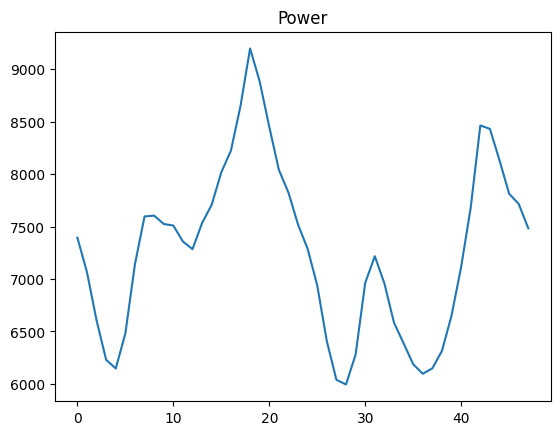

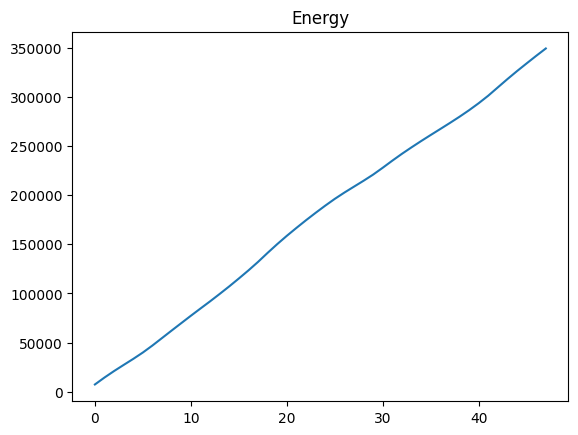

In [215]:
r = np.random.randint(0, len(load)//window_size-1)
print(load.index[window_size*r], "-> ", load.index[window_size*(r+1)])

power = np.array(load.values[window_size*r: window_size*(r+1)])
energy = np.cumsum(power)

plt.plot(power)
plt.title("Power")
plt.show()

plt.plot(energy)
plt.title("Energy")
plt.show()

In [216]:
def _anomaly_type1(target, indices, lengths, k=0):
    """
    Anomaly type 1 that drops the power time series values to a negative value potentially followed by zero values
    before adding the missed sum of power to the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 2:
            raise Exception("Type 1 power anomalies must be longer than 2.")
        else:
            # WARNING: This could lead to a overflow quite fast?
            energy_at_start = target[:idx].sum() + k
            energy_at_end = target[:idx + length].sum() + k
            target[idx] = -1 * energy_at_start          # replace first by negative peak
            target[idx + 1:idx + length - 1] = 0        # set other values to zero
            target[idx + length - 1] = energy_at_end    # replace last with sum of missing values + k
    return target

def _anomaly_type2(target, indices, lengths, softstart=True):
    """
    Anomaly type 2 that drops the power time series values to potentially zero and adds the missed sum of power to
    the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 1:
            raise Exception("Type 2 power anomalies must be longer than 1.")
        else:
            if softstart:
                r = np.random.rand()
                energy_consumed = target[idx:idx + length].sum()
                target[idx] = r * target[idx]
                target[idx + 1:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed - target[idx]
            else:
                energy_consumed = target[idx:idx + length].sum()
                target[idx:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed
    return target

def _anomaly_type3(target, indices, lengths,
                    is_extreme=False, range_r=(0.01, 3.99), k=0):
    """
    Anomaly type 3 that creates a negatives peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 3 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = -1 * energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = -1 * r * target[idx - 1]
    return target

def _anomaly_type4(target, indices, lengths,
                   is_extreme=False, range_r=(0.01, 3.99), k=0):
    """
    Anomaly type 4 that creates a positive peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 4 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = r * target[idx - 1]
    return target


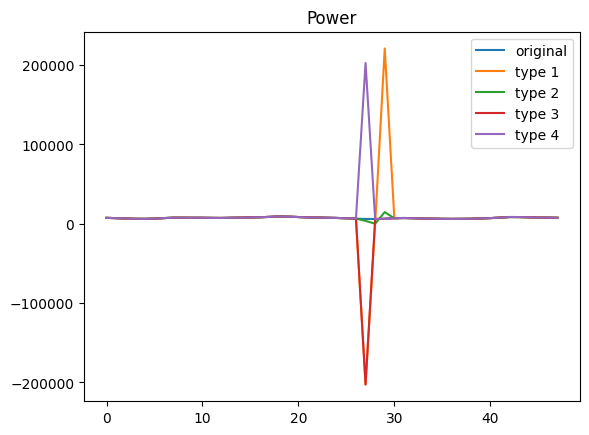

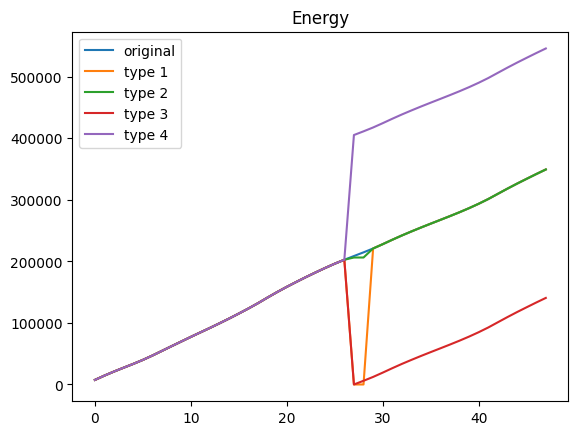

In [217]:
position = np.random.randint(len(power)//4, (len(power)-1)//5*4)
length = np.random.randint(3, len(power)-1-position)

anomalous_power_type_1 = _anomaly_type1(power.copy(), [position], [length])
anomalous_power_type_2 = _anomaly_type2(power.copy(), [position], [length])
anomalous_power_type_3 = _anomaly_type3(power.copy(), [position], [1], is_extreme=True)
anomalous_power_type_4 = _anomaly_type4(power.copy(), [position], [1], is_extreme=True)

plt.plot(power, label="original")
plt.plot(anomalous_power_type_1, label="type 1")
plt.plot(anomalous_power_type_2, label="type 2")
plt.plot(anomalous_power_type_3, label="type 3")
plt.plot(anomalous_power_type_4, label="type 4")
plt.title("Power")
plt.legend()
plt.show()

energy = np.cumsum(power)
anomalous_energy_1 = np.cumsum(anomalous_power_type_1)
anomalous_energy_2 = np.cumsum(anomalous_power_type_2)
anomalous_energy_3 = np.cumsum(anomalous_power_type_3)
anomalous_energy_4 = np.cumsum(anomalous_power_type_4)
plt.plot(energy, label="original")
plt.plot(anomalous_energy_1, label="type 1")
plt.plot(anomalous_energy_2, label="type 2")
plt.plot(anomalous_energy_3, label="type 3")
plt.plot(anomalous_energy_4, label="type 4")
plt.title("Energy")
plt.legend()
plt.show()

## Contaminating & saving data

In [218]:
def inject_anomaly(sequence, anom_type=0, n_anom=1, minimum_length=10):
    sequence = sequence.copy()
    n = len(sequence)
    # TODO add handling multiple number of anomalies

    if anom_type==0:
        anom_type = np.random.randint(1, 4)

    if anom_type==1:
        position = np.random.randint(n//4, (len(sequence)-1)//2)
        remaining_length = len(sequence)-1-position
        length = np.random.randint(max(3, (remaining_length//3*2)), remaining_length)
        return _anomaly_type1(sequence.copy(), [position], [length])
    
    if anom_type==2:
        position = np.random.randint(n//4, (len(sequence)-1)//2)
        remaining_length = len(sequence)-1-position
        length = np.random.randint(max(2, (remaining_length//3*2)), remaining_length)
        return _anomaly_type2(sequence.copy(), [position], [length])
    
    if anom_type==3:
        position = np.random.randint(n//4, (len(sequence)-1)//3*2)
        return _anomaly_type3(sequence, [position], [1])
    
    if anom_type==4:
        position = np.random.randint(n//4, (len(sequence)-1)//3*2)
        return _anomaly_type4(sequence, position, [1])


In [223]:
# parameters

contam_ratio = 0.2          # real day contam rate is contam_ratio/n_days as we add a single anomaly per day, /=day_size to get point contam rate
clean_contam_ratio = 0.15   # we save clean data to later evaluate the forecasting model on
ad_split_ratio = 0.6        # contam data is split into train and test sets for the anomaly detection model
trg_save_data = "../../dataset/processed/AEMO/NSW"
n_days = 3
day_size = 48

In [220]:
# split contam data into train and test sets for anomaly detection model

N = int(clean_contam_ratio*len(load))//day_size*day_size
M = int(ad_split_ratio*(len(load)-N))//day_size*day_size

clean_load = load[:N]
contam_load = load[N:]

ad_train_load = contam_load[:M]
ad_test_load = contam_load[M:]

In [221]:
# build time_windows data of n_days consecutive days, with stride of 1 day

def slice_sequence(load, day0, n_days, day_size):
    """return n_days consecutive days starting at day0 from load dataframe"""

    sequence = []
    start = day0
    end = start + window_size

    for day in range(n_days):
        sequence.extend(load[feature_name].values[start: end])
        start += day_size
        end += day_size
    return np.array(sequence)

def build_dataset(load, n_days, day_size, contam_ratio):
    """
        build a dataset from load dataframe using a sliding window of size n_days and stride of 1 day 
        while contamining the data with synthetic anomalies
    """
    data = []
    gt = []
    for i in range(len(load)//day_size - n_days*day_size):
        day0 = i*day_size
        sequence = slice_sequence(load, day0, n_days, day_size)

        contam = np.random.random()<contam_ratio
        if contam:
            sequence = inject_anomaly(sequence, anom_type=0, n_anom=1)
            gt.append([1]*len(sequence)) # TODO store exact position of anomaly
        else: gt.append([0]*len(sequence))

        data.append(sequence)
    return data, gt


clean_windows, gt_clean_windows = build_dataset(clean_load, n_days=n_days, day_size=day_size, contam_ratio=0)
ad_train_windows, gt_ad_train_windows = build_dataset(ad_train_load, n_days=n_days, day_size=day_size, contam_ratio=contam_ratio)
ad_test_windows, gt_ad_test_windows = build_dataset(ad_test_load, n_days=n_days, day_size=day_size, contam_ratio=contam_ratio)

In [44]:
print(f"Number of clean windows: {len(clean_windows)}")
print(f"Number of ad_train_contam windows: {len(ad_train_windows)}")
print(f"Number of ad_test_contam windows: {len(ad_test_windows)}")

Number of clean windows: 138
Number of ad_train_contam windows: 645
Number of ad_test_contam windows: 406


In [222]:
# remove existing files in save target root folder
existing_files = glob.glob(os.path.join(trg_save_data, "*", "*", "*.npy"))
for f in existing_files:
    os.remove(f)
# crete save target folders if they don't exist
os.makedirs(os.path.join(trg_save_data, "lf_test_clean", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_train_contam", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_train_contam", "gt"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_test_contam", "data"), exist_ok=True)
os.makedirs(os.path.join(trg_save_data, "ad_test_contam", "gt"), exist_ok=True)

# save clean lf data
for i, sample in enumerate(clean_windows):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "lf_test_clean", "data", str(i)), sample)

# save contam ad train data
for i, (sample, sample_gt) in enumerate(zip(ad_train_windows, gt_ad_train_windows)):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "ad_train_contam", "data", str(i)), sample)
    np.save(os.path.join(trg_save_data, "ad_train_contam", "gt", str(i)), sample_gt)

# save contam ad test data
for i, (sample, sample_gt) in enumerate(zip(ad_test_windows, gt_ad_test_windows)):
    if np.isnan(sample).any(): continue
    np.save(os.path.join(trg_save_data, "ad_test_contam", "data", str(i)), sample)
    np.save(os.path.join(trg_save_data, "ad_test_contam", "gt", str(i)), sample_gt)


In [46]:
# path = "../../results/data_display"
# os.makedirs(path, exist_ok=True)

# for j, (sample, sample_gt) in enumerate(zip(ad_test_windows, gt_ad_test_windows)):
#     plt.plot(sample)
#     plt.title(f"gt: {sample_gt.count(1)/len(sample_gt)>0}")
#     plt.savefig(f"../../results/data_display/{j}.png")
#     plt.clf()